In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import numpy as np

In [2]:
plot_folder = "plots/ind_study"
os.makedirs(plot_folder, exist_ok=True)

In [3]:
root_folder = "tunings"

# get all paths
all_paths = []
for dataset_folder in os.listdir(root_folder):
    if not os.path.isdir(os.path.join(root_folder, dataset_folder)):
        continue
    for tune_folder in os.listdir(os.path.join(root_folder, dataset_folder)):
        tune_path = os.path.join(root_folder, dataset_folder, tune_folder)
        all_paths.append(tune_path)

# get all configs, and best params
all_cfgs = []
all_best_params = []
all_scores = []
for tune_path in all_paths:
    try:
        # load cfg and best params
        with open(os.path.join(tune_path, "cfg.json"), "r") as f:
            cfg = json.load(f)
        best_params = pd.read_csv(os.path.join(tune_path, "best_params.csv"), index_col=0)
        scores = pd.read_csv(os.path.join(tune_path, "scores.csv"), index_col=0)
        
        try:
            clipped_means = pd.read_csv(os.path.join(tune_path, "metrics_mean_clipped.csv"), index_col=0)
            clipped_means = clipped_means.T.iloc[0].to_dict()
            cfg.update(clipped_means)
        except FileNotFoundError:
            print(f"Could not all metrics in {tune_path}")
        
        for param in best_params:
            if param in cfg:
                cfg[param] = best_params[param].values[0]
                
        for key in scores:
            cfg[key] = scores[key].values[0]
            
        # add date and time
        name = tune_path.split("/")[-1]
        date = name.split("_")[:1]
        time = name.split("_")[1:2]
        datetime = pd.to_datetime("_".join(name.split("_")[:2]), format="%Y-%m-%d_%H-%M-%S")
        cfg["datetime"] = datetime
        # store
        all_cfgs.append(cfg)
        all_best_params.append(best_params)
        all_scores.append(scores)
    except FileNotFoundError:
        print(f"Could not load files in {tune_path}")

Could not all metrics in tunings/MIMIC_60/2022-12-09_13-26-21_rnn_50_inner10
Could not load files in tunings/MIMIC_60/2023-01-18_03-57-27_rnn_50_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-13_21-06-56_transformer_50_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-16_13-21-26_rnn_5_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-12_11-57-18_transformer_50_inner10
Could not load files in tunings/MIMIC_60/2023-01-17_20-55-14_rnn_50_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-18_14-41-37_xgb_50_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-18_14-16-27_xgb_50_inner10
Could not load files in tunings/MIMIC_60/2023-01-16_15-12-44_transformer_50_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-16_10-30-22_rnn_2_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-14_16-34-51_rnn_10_inner10
Could not load files in tunings/MIMIC_60/2023-01-17_14-53-36_rnn_50_inner10
Could not all metrics in tunings/MIMIC_60/2022-12-19_05-54

In [4]:
def clean_cols(df):
    df = df.drop(columns=df.nunique()[df.nunique()<=1].index).sort_values("cross_val_score_tune")
    return df

In [5]:
# merge best param list of dfs in one big df
all_best_params_df = pd.concat(all_best_params)#.drop(columns=["fill_type"])
# merge cfg list to it
df = pd.DataFrame(all_cfgs)

df = df[df["opt_steps"] == 50]
# merge cfg and best params df, avoiding reindexing error
#all_df = pd.concat([all_cfgs_df.reset_index(drop=True), all_best_params_df.reset_index(drop=True)], axis=1)
# drop all coumns that contain only one unique value
df = df.drop(columns=df.nunique()[df.nunique()<=1].index).sort_values("cross_val_score_tune")

# nan embedding was buggy before 12.02.23 - remove all runs
def remove_buggy_nan_embed(df):
    cutoff_date_str = "2023-02-12 00:00:00"
    cutoff_datetime = pd.to_datetime(cutoff_date_str, format="%Y-%m-%d %H:%M:%S")
    df = df[(df["use_nan_embed"] == False) | (df["datetime"] > cutoff_datetime)]
    return df
df = remove_buggy_nan_embed(df)

In [6]:
df[df["use_nan_embed"] == True]

,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
97,rnn,MIMIC,60,xl,1,none,64,0,4,2,...,6.829613,0.000113,75.445808,0.942438,0.833769,0.165747,5.692119,4.449522,0.920710,0.753449
138,rnn,MIMIC,60,xl,1,none,128,0,4,4,...,6.920128,0.000293,75.434959,0.939329,0.834862,0.143447,5.620712,4.332708,0.916248,0.757183
87,rnn,MIMIC,60,xl,1,none,32,0,4,2,...,6.861498,0.000122,75.572044,0.942235,0.830086,0.157937,5.754350,4.514976,0.919833,0.752125
136,rnn,MIMIC,60,xl,1,none,8,0,4,3,...,6.939959,0.000146,75.068481,0.941385,0.818135,0.138537,5.595566,4.290755,0.917656,0.740964
107,rnn,MIMIC,60,xl,1,none,2,0,4,3,...,6.971033,0.000181,74.745781,0.945394,0.790078,0.130839,5.568392,4.290792,0.927879,0.705205
312,rnn,UKE,60,xl,1,none,64,0,4,3,...,7.830246,0.000242,91.607338,0.937830,0.817586,0.392123,5.424601,4.015827,0.925590,0.715405
206,rnn,UKE,60,xl,1,none,32,0,4,3,...,7.965559,0.000143,90.658966,0.937737,0.806784,0.370407,5.526793,3.991706,0.925749,0.700919
161,rnn,UKE,60,xl,1,none,8,0,4,3,...,8.488842,0.000342,91.309937,0.938165,0.779443,0.284662,5.660402,4.043283,0.929075,0.687043
292,rnn,UKE,60,xl,1,none,2,0,4,2,...,9.322577,0.000202,90.772926,0.932631,0.781409,0.138254,5.066792,3.905043,0.924950,0.694870


In [7]:
# best model per db
best_model = df.groupby(["db_name", "model_type"]).apply(lambda x: x.groupby("model_size").mean().sort_values("cross_val_score_tune"))

/tmp/ipykernel_135167/2296588613.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  best_model = df.groupby(["db_name", "model_type"]).apply(lambda x: x.groupby("model_size").mean().sort_values("cross_val_score_tune"))
/tmp/ipykernel_135167/2296588613.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  best_model = df.groupby(["db_name", "model_type"]).apply(lambda x: x.groupby("model_size").mean().sort_values("cross_val_score_tune"))
/tmp/ipykernel_135167/2296588613.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default

In [8]:
best_model["cross_val_score_tune"]

db_name  model_type   model_size
MIMIC    linear       base          52.530870
         rnn          xl            50.688568
                      xxl           51.203476
                      tiny          54.971271
                      small         55.496357
                      xt            55.829643
                      base          56.390597
                      large         56.534387
         transformer  xt            52.434057
                      tiny          56.766430
                      small         57.908393
                      large         58.948285
                      base          59.231833
                      xl            59.499357
         xgb          base          54.720962
UKE      linear       base          89.788353
         rnn          xl            66.134036
                      tiny          71.004016
                      small         71.228112
                      xt            71.605072
                      base          73.476819
 

In [9]:
best_model["test_score"]

db_name  model_type   model_size
MIMIC    linear       base          48.291327
         rnn          xl            48.030238
                      xxl           46.119563
                      tiny          54.619978
                      small         54.546536
                      xt            54.871669
                      base          57.061552
                      large         55.796742
         transformer  xt            52.135002
                      tiny          59.223832
                      small         59.100127
                      large         62.931301
                      base          60.324659
                      xl            64.682759
         xgb          base          50.014437
UKE      linear       base          85.107884
         rnn          xl            68.849663
                      tiny          73.977468
                      small         74.691385
                      xt            76.063700
                      base          75.116624
 

In [10]:
best_model["cross_val_score_tune"]

db_name  model_type   model_size
MIMIC    linear       base          52.530870
         rnn          xl            50.688568
                      xxl           51.203476
                      tiny          54.971271
                      small         55.496357
                      xt            55.829643
                      base          56.390597
                      large         56.534387
         transformer  xt            52.434057
                      tiny          56.766430
                      small         57.908393
                      large         58.948285
                      base          59.231833
                      xl            59.499357
         xgb          base          54.720962
UKE      linear       base          89.788353
         rnn          xl            66.134036
                      tiny          71.004016
                      small         71.228112
                      xt            71.605072
                      base          73.476819
 

In [11]:
df.sort_values("cross_val_score_tune")

,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
334,rnn,MIMIC,120,xl,1,ffill,128,0,3,3,...,6.543535,0.000209,76.016258,0.944492,0.834469,0.198823,5.943817,4.627649,0.909826,0.741587
333,rnn,MIMIC,120,xl,3,ffill,128,0,3,4,...,6.495756,0.000366,76.026176,0.946940,0.831780,0.210461,5.940111,4.616974,0.913039,0.734204
332,rnn,MIMIC,120,xl,2,ffill,128,0,3,3,...,6.602162,0.000347,74.925720,0.939807,0.838893,0.184415,5.902086,4.622775,0.904177,0.749661
85,rnn,MIMIC,60,xl,11,median,128,0,3,2,...,6.735030,0.000148,75.995522,0.943618,0.832498,0.188695,5.792072,4.530372,0.920417,0.748789
13,rnn,MIMIC,60,xl,10,median,128,0,3,3,...,6.749510,0.000346,76.038277,0.944671,0.834062,0.185181,5.718287,4.445524,0.921692,0.755706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,transformer,UKE,60,base,2,ffill,128,0,3,5,...,8.663568,0.000230,90.140236,0.927826,0.793786,0.255751,5.879947,4.145474,0.918375,0.695263
194,linear,UKE,60,base,11,ffill,128,0,3,8,...,9.393249,0.000045,87.517614,0.937964,0.769572,0.125248,4.671941,3.577294,0.937430,0.658937
229,transformer,UKE,60,large,1,ffill,128,0,3,3,...,8.435943,0.000105,92.598213,0.929626,0.803925,0.294372,5.855627,4.268050,0.919046,0.713359
279,rnn,UKE,60,xl,2,none,8,True,4,2,...,9.616107,0.000103,91.584167,0.907375,0.751593,0.083149,5.559067,4.248163,0.891827,0.675884


MIMIC
Saving to plots/ind_study/Model_sizes_MIMIC.pdf


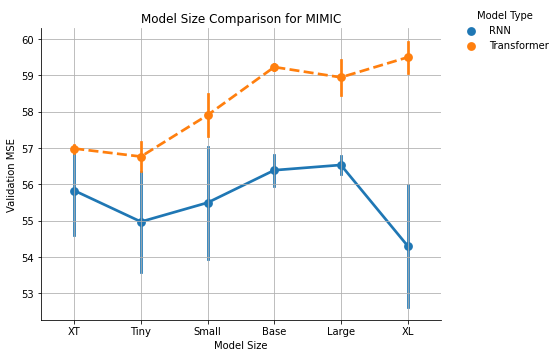

UKE
Saving to plots/ind_study/Model_sizes_UKE.pdf


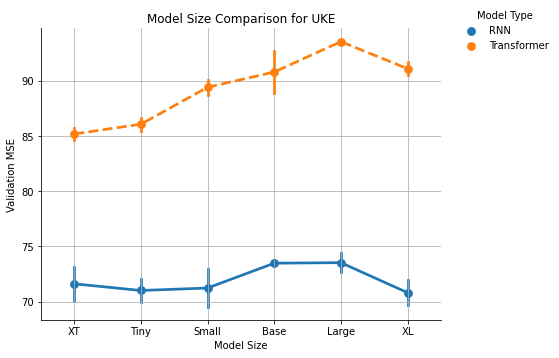

In [12]:
metric = "cross_val_score_tune"
#metric = "bs"
#metric = "test_score"
#metric = "r2"
#metric = "mse"
#metric = "hyp_auc"

dl_df = df[(df.model_type == "transformer") | (df.model_type == "rnn")]
#dl_df = df


# minutes==60
dl_df = dl_df[dl_df.minutes == 60]

# block size 8!
dl_df = dl_df[dl_df.block_size == 8]

cutoff_date_str = "2022-12-21 00:00:00"
cutoff_datetime = pd.to_datetime(cutoff_date_str, format="%Y-%m-%d %H:%M:%S")
dl_df = dl_df[dl_df["datetime"] < cutoff_datetime]
# eval model size
for db in dl_df.db_name.unique():
    print(db)
    
    df_db = dl_df[dl_df["db_name"] == db]
    #df_db = df
    
    g = sns.catplot(data=df_db, x="model_size", y=metric,
                order=['xt', 'tiny', "small", "base", "large", "xl"],
                hue="model_type",
                linestyles=["-", "--"],
                kind="point",
                legend=True,
                #errorbar=("ci", 95),
                errorbar="se",
                )

               
    
    xticks = ['XT', 'Tiny', "Small", "Base", "Large", "XL"]
    plt.xticks(range(len(xticks)), xticks)
    plt.xlabel("Model Size")
    plt.ylabel("Validation MSE")
    plt.title(f"Model Size Comparison for {db}")
    plt.grid(True)
    ## Rename legend
    new_title = 'Model Type'
    g._legend.set_title(new_title)
    # replace labels
    new_labels = ['RNN', 'Transformer']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    # move legend outside
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()

    
    name = f"Model_sizes_{db}"
    plot_path1 = os.path.join(plot_folder, f"{name}.pdf")
    plot_path2 = os.path.join(plot_folder, f"{name}.png")
    print(f"Saving to {plot_path1}")
    plt.savefig(plot_path1)
    plt.savefig(plot_path2, bbox_inches='tight')
    plt.show()
    
    
    ## test results - only used for debugging, not model selection!
    #sns.catplot(data=df_db, x="model_size", y="test_score",
    #                            order=['tiny', "small", "base", "large"],#, "xl"]
    #            hue="model_type",
    #            linestyles=["-", "--"],
    #            kind="point"
    #           )
    #plt.title(f"{db} test")
    #plt.show()

In [13]:
dl_df.groupby(["db_name", "model_size", "model_type"]).count()

minutes  seed  fill_type  nan_embed_size  \
db_name model_size model_type                                              
MIMIC   base       rnn                2     2          2               2   
                   transformer        2     2          2               2   
        large      rnn                2     2          2               2   
                   transformer        2     2          2               2   
        small      rnn                4     4          4               4   
                   transformer        4     4          4               4   
        tiny       rnn                4     4          4               4   
                   transformer        4     4          4               4   
        xl         rnn                3     3          3               3   
                   transformer        3     3          3               3   
        xt         rnn                5     5          5               5   
                   transformer        4     4          4               4   
UKE     base       rnn                2     2          2               2   
                   transformer        2     2          2               2   
        large      rnn                2     2          2               2   
                   transformer        1     1          1               1   
        small      rnn                3     3          3               3   
                   transformer        2     2          2               2   
        tiny       rnn                4     4          4               4   
                   transformer        5     5          5               5   
        xl         rnn                3     3          3               3   
                   transformer        3     3          3               3   
        xt         rnn                3     3          3               3   
                   transformer        3     3          3               3   

                                use_nan_embed_transformer  \
db_name model_size model_type                               
MIMIC   base       rnn                                  2   
                   transformer                          2   
        large      rnn                                  2   
                   transformer                          2   
        small      rnn                                  4   
                   transformer                          4   
        tiny       rnn                                  4   
                   transformer                          4   
        xl         rnn                                  3   
                   transformer                          3   
        xt         rnn                                  5   
                   transformer                          4   
UKE     base       rnn                                  2   
                   transformer                          2   
        large      rnn                                  2   
                   transformer                          1   
        small      rnn                                  3   
                   transformer                          2   
        tiny       rnn                                  4   
                   transformer                          5   
        xl         rnn                                  3   
                   transformer                          3   
        xt         rnn                                  3   
                   transformer                          3   

                                nan_embed_transformer_n_layers  bs  \
db_name model_size model_type                                        
MIMIC   base       rnn                                       2   2   
                   transformer                               2   2   
        large      rnn                                       2   2   
                   transformer                               2   2   
        small      rnn                          

In [14]:
df[df.db_name == "MIMIC"].sort_values("r2")["r2"].dropna()

51     0.021752
96     0.025503
108    0.028038
53     0.030282
29     0.045133
         ...   
122    0.190484
81     0.192132
7      0.195268
334    0.198823
333    0.210461
Name: r2, Length: 129, dtype: float64

In [15]:
dl_df.groupby(["db_name", "model_size", "model_type"]).std()

/tmp/ipykernel_135167/1547408360.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dl_df.groupby(["db_name", "model_size", "model_type"]).std()


minutes      seed  nan_embed_size  \
db_name model_size model_type                                       
MIMIC   base       rnn              0.0  0.707107             0.0   
                   transformer      0.0  0.707107             0.0   
        large      rnn              0.0  0.707107             0.0   
                   transformer      0.0  1.414214             0.0   
        small      rnn              0.0  1.707825             0.0   
                   transformer      0.0  1.290994             0.0   
        tiny       rnn              0.0  1.414214             0.0   
                   transformer      0.0  0.957427             0.0   
        xl         rnn              0.0  2.081666             0.0   
                   transformer      0.0  0.577350             0.0   
        xt         rnn              0.0  1.224745             0.0   
                   transformer      0.0  0.957427             0.0   
UKE     base       rnn              0.0  0.707107             0.0   
                   transformer      0.0  0.707107             0.0   
        large      rnn              0.0  0.707107             0.0   
                   transformer      NaN       NaN             NaN   
        small      rnn              0.0  2.081666             0.0   
                   transformer      0.0  0.707107             0.0   
        tiny       rnn              0.0  1.732051             0.0   
                   transformer      0.0  1.095445             0.0   
        xl         rnn              0.0  2.081666             0.0   
                   transformer      0.0  0.577350             0.0   
        xt         rnn              0.0  1.732051             0.0   
                   transformer      0.0  1.154701             0.0   

                                nan_embed_transformer_n_layers        bs  \
db_name model_size model_type                                              
MIMIC   base       rnn                                     0.0  0.000000   
                   transformer                             0.0  0.000000   
        large      rnn                                     0.0  0.707107   
                   transformer                             0.0  0.000000   
        small      rnn                                     0.0  0.500000   
                   transformer                             0.0  0.577350   
        tiny       rnn                                     0.0  0.577350   
                   transformer                             0.0  0.000000   
        xl         rnn                                     0.0  0.577350   
                   transformer                             0.0  1.154701   
        xt         rnn                                     0.0  0.547723   
                   transformer                             0.0  0.500000   
UKE     base       rnn                                     0.0  0.000000   
                   transformer                             0.0  0.707107   
        large      rnn                                     0.0  0.000000   
                   transformer                             NaN       NaN   
        small      rnn                                     0.0  0.577350   
                   transformer                             0.0  0.707107   
        tiny       rnn                                     0.0  0.500000   
                   transformer                             0.0  1.303840   
        xl         rnn                                     0.0  0.000000   
                   transformer                             0.0  0.000000   
        xt         rnn                                     0.0  1.154701   
                   transformer                             0.0  0.577350   

                                block_size            lr  weight_decay  \
db_name model_size model_type                                            
MIMIC   base       rnn                 0.0  6.677167e-05      0.000000   
                   transformer        

In [16]:
def not_too_old(df):
    cutoff_date_str = "2022-12-21 00:00:00"
    cutoff_datetime = pd.to_datetime(cutoff_date_str, format="%Y-%m-%d %H:%M:%S")
    df = df[df["datetime"] > cutoff_datetime]
    return df

In [17]:
#xgb_df.sort_values("flat_block_size")

In [18]:
#python3 tune.py gpu=1 model_type="rnn" block_size=1,8,32 db_name="eICU" seed=2,3 -m

In [19]:
# TO RUN:

In [20]:
df.only_med_and_demo_features

334      NaN
333      NaN
332      NaN
85       NaN
13       NaN
       ...  
286      NaN
194      NaN
229      NaN
279    False
295    False
Name: only_med_and_demo_features, Length: 306, dtype: object

In [21]:
df.columns

Index(['model_type', 'db_name', 'minutes', 'model_size', 'seed', 'fill_type',
       'nan_embed_size', 'use_nan_embed_transformer',
       'nan_embed_transformer_n_layers', 'bs', 'block_size', 'lr',
       'use_nan_embed', 'weight_decay', 'grad_clip_val', 'dropout',
       'flat_block_size', 'alpha', 'l1_ratio', 'n_estimators', 'max_depth',
       'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'gpu',
       'cross_val_score_tune', 'test_score', 'test_score_std', 'datetime',
       'only_med_and_demo_features', 'use_general_features', 'mse', 'mae',
       'rmse', 'min_abs_error', 'max_abs_error', 'hyp_acc', 'hyp_auc', 'r2',
       'rmse_clin', 'mae_clin', 'hyp_acc_clin', 'hyp_auc_clin'],
      dtype='object')

Saving to plots/ind_study/Block_sizes_MIMIC_cross_val_score_tune.pdf
Saving to plots/ind_study/Block_sizes_UKE_cross_val_score_tune.pdf
Saving to plots/ind_study/Block_sizes_eICU_cross_val_score_tune.pdf


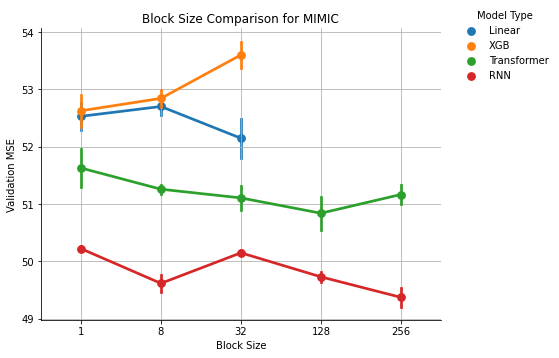

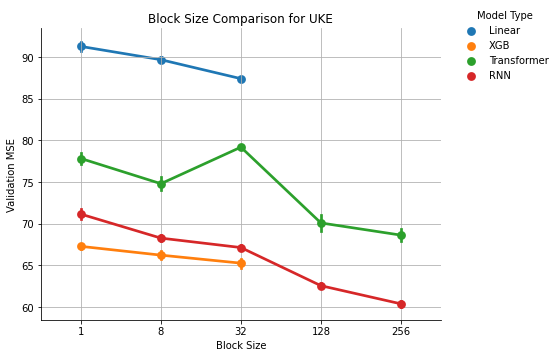

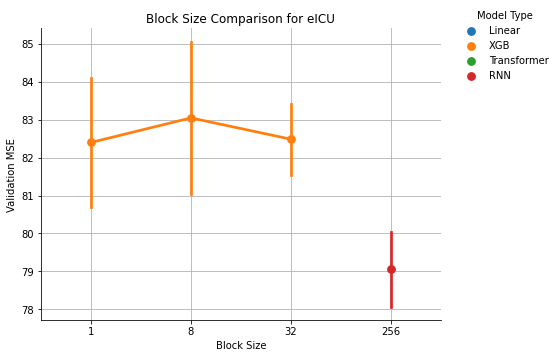

In [22]:
# per db
metric = "cross_val_score_tune"
#metric = "test_score"
#metric = "r2"
#metric = "hyp_auc"

block_df = not_too_old(df)
# filter sizes for dl models
block_df = block_df[(block_df.model_size == "xl") | (~(block_df.model_type == "rnn"))]
block_df = block_df[(block_df.model_size == "xt") | (~(block_df.model_type == "transformer"))]

# filter minutes
block_df = block_df[block_df.minutes == 60]

# filter fill type
block_df = block_df[block_df.fill_type == "ffill"]

# use all features
block_df = block_df[block_df.only_med_and_demo_features != True]
block_df = block_df[block_df.use_general_features != True]

block_df = block_df[block_df.use_nan_embed == False]

# merge block size and flat block size
block_df["block"] = list(block_df.apply(lambda x: x.block_size if x.model_type in ["rnn", "transformer"] else x.flat_block_size, axis=1))
# only select some interesting block sizes to visualize
block_df = block_df[block_df.apply(lambda x: x.block in (1, 8, 32, 128, 256), axis=1)]
block_df = clean_cols(block_df)


for db in df.db_name.unique():
    df_db = block_df[block_df["db_name"] == db]
    
    #df_db = clean_cols(df_db)
    
    g = sns.catplot(data=df_db, x="block", y=metric,
                    #order=['xt', 'tiny', "small", "base", "large", "xl"],
                    hue="model_type",
                    hue_order=["linear", "xgb", "transformer", "rnn"],
                    #linestyles=["-", "--"],
                    #kind="point",
                    errorbar="se",
                    kind="point",
               )
    
    #xticks = ['XT', 'Tiny', "Small", "Base", "Large", "XL"]
    #plt.xticks(range(len(xticks)), xticks)
    plt.xlabel("Block Size")
    plt.ylabel("Validation MSE")
    plt.title(f"Block Size Comparison for {db}")
    plt.grid(True)
    ## Rename legend
    new_title = 'Model Type'
    g._legend.set_title(new_title)
    # replace labels
    new_labels = ["Linear", "XGB", 'Transformer', 'RNN']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    # move legend outside
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    
    name = f"Block_sizes_{db}_{metric}"
    plot_path1 = os.path.join(plot_folder, f"{name}.pdf")
    plot_path2 = os.path.join(plot_folder, f"{name}.png")
    
    plt.title("Block Size Comparison for " + db)
    print(f"Saving to {plot_path1}")
    plt.savefig(plot_path1)
    plt.savefig(plot_path2, bbox_inches='tight')
    
    
    #sns.scatterplot(data=df_db, x="block", y=metric,
    #            #order=['xt', 'tiny', "small", "base", "large", "xl"],
    #            hue="model_type",
    #            hue_order=["linear", "xgb", "transformer", "rnn"],
    #            #linestyles=["-", "--"],
    #            #kind="point"
    #           )

In [23]:
### table

block_df = not_too_old(df)
# filter sizes for dl models
block_df = block_df[(block_df.model_size == "xl") | (~(block_df.model_type == "rnn"))]
block_df = block_df[(block_df.model_size == "xt") | (~(block_df.model_type == "transformer"))]

# filter minutes
block_df = block_df[block_df.minutes == 60]

# filter fill type
block_df = block_df[block_df.fill_type == "ffill"]

# use all features
block_df = block_df[block_df.only_med_and_demo_features != True]
block_df = block_df[block_df.use_general_features != True]

block_df = block_df[block_df.use_nan_embed == False]

# merge block size and flat block size
block_df["block"] = list(block_df.apply(lambda x: x.block_size if x.model_type in ["rnn", "transformer"] else x.flat_block_size, axis=1))
# only select some interesting block sizes to visualize
block_df = block_df[block_df.apply(lambda x: x.block in (1, 8, 32, 128, 256), axis=1)]

block_df = block_df[(block_df.model_type != "rnn") | (block_df.block == 256)]
block_df = block_df[(block_df.model_type != "transformer") | (block_df.block == 256)]
block_df = block_df[(block_df.model_type != "linear") | (block_df.block == 32)]
block_df = block_df[(block_df.model_type != "xgb") | (block_df.block == 8)]

block_df = clean_cols(block_df)

block_df.columns

Index(['model_type', 'db_name', 'model_size', 'seed', 'nan_embed_size',
       'nan_embed_transformer_n_layers', 'bs', 'block_size', 'lr',
       'weight_decay', 'grad_clip_val', 'dropout', 'flat_block_size', 'alpha',
       'l1_ratio', 'n_estimators', 'max_depth', 'min_child_weight', 'gamma',
       'subsample', 'colsample_bytree', 'gpu', 'cross_val_score_tune',
       'test_score', 'test_score_std', 'datetime', 'mse', 'mae', 'rmse',
       'min_abs_error', 'max_abs_error', 'hyp_acc', 'hyp_auc', 'r2',
       'rmse_clin', 'mae_clin', 'hyp_acc_clin', 'hyp_auc_clin', 'block'],
      dtype='object')

In [24]:
block_df

,model_type,db_name,model_size,seed,nan_embed_size,nan_embed_transformer_n_layers,bs,block_size,lr,weight_decay,...,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin,block
26,rnn,MIMIC,xl,10,128,3,3,256,0.000030,0.22,...,0.000291,76.432579,0.938403,0.827928,0.166760,5.990079,4.670472,0.909477,0.741077,256
46,rnn,MIMIC,xl,12,128,3,3,256,0.000116,0.36,...,0.000161,74.350464,0.944836,0.823410,0.186606,5.904999,4.561614,0.918479,0.731150,256
134,rnn,MIMIC,xl,19,128,3,2,256,0.000098,0.12,...,0.000333,74.400002,0.943136,0.827581,0.180582,5.913236,4.611935,0.916487,0.741174,256
27,rnn,MIMIC,xl,18,128,3,4,256,0.000025,0.00,...,0.000276,74.996544,0.935358,0.828986,0.161197,5.916434,4.606479,0.903715,0.738266,256
122,rnn,MIMIC,xl,11,128,3,3,256,0.000162,0.24,...,0.000148,74.653145,0.945432,0.826102,0.190484,5.957064,4.599122,0.920975,0.735237,256
109,transformer,MIMIC,xt,49,128,3,3,256,0.004675,0.34,...,0.000146,75.840111,0.933087,0.804936,0.114618,5.992840,4.599755,0.904883,0.723136,256
11,transformer,MIMIC,xt,22,128,3,3,256,0.000993,0.32,...,0.000162,76.251381,0.923825,0.801986,0.068036,6.140747,4.691601,0.894633,0.719826,256
23,transformer,MIMIC,xt,23,128,3,3,256,0.000968,0.30,...,0.000219,75.843506,0.931387,0.798074,0.109885,5.960791,4.576943,0.900714,0.715991,256
30,linear,MIMIC,base,21,128,3,8,8,NaN,0.20,...,0.000196,74.779920,0.941044,0.822240,0.139303,5.697507,4.388896,0.920344,0.739298,32
62,transformer,MIMIC,xt,50,128,3,2,256,0.000363,0.40,...,0.000234,75.477715,0.934089,0.805358,0.121898,5.711395,4.430845,0.906105,0.722133,256


In [25]:
unnecessary_cols = ["flat_block_size", "block_size", "min_abs_error", "max_abs_error", "hyp_acc_clin", "hyp_auc_clin", "test_score_std", "seed", "gpu"]

means = block_df.groupby("db_name").apply(lambda db: db.groupby("model_type").mean(numeric_only=True)).drop(columns=unnecessary_cols)
stds = block_df.groupby("db_name").apply(lambda db: db.groupby("model_type").std(numeric_only=True)).drop(columns=unnecessary_cols)
means["hyp_auc"] *= 100
stds["hyp_auc"] *= 100
means["hyp_acc"] *= 100
stds["hyp_acc"] *= 100
metric_cols = ["test_score", "mse","rmse", "mae", "hyp_acc", "hyp_auc", "r2", "rmse_clin", "mae_clin", "cross_val_score_tune"]
means[metric_cols].round(3)
metric_cols = ["test_score", "rmse", "mae", "hyp_acc", "hyp_auc", "r2", "rmse_clin", "mae_clin", "cross_val_score_tune"]
stds[metric_cols].round(3)
str_table = means[metric_cols].round(2).astype(str)  + " +- " + stds[metric_cols].round(2).astype(str) 
str_table.reset_index()
str_table.to_csv("plots/ind_study/table_general.csv")

In [26]:
str_table

test_score          rmse           mae        hyp_acc  \
db_name model_type                                                              
MIMIC   linear        48.1 +- 0.04   6.94 +- 0.0   4.77 +- 0.0   94.1 +- 0.01   
        rnn           46.0 +- 0.73  6.78 +- 0.05  4.69 +- 0.05  94.14 +- 0.44   
        transformer   50.06 +- 1.3  7.08 +- 0.09  4.88 +- 0.05  93.06 +- 0.47   
        xgb          47.36 +- 1.47  6.88 +- 0.11   4.7 +- 0.06   94.03 +- 0.4   
UKE     linear       83.49 +- 0.03   9.14 +- 0.0  5.68 +- 0.02  93.34 +- 0.07   
        rnn          59.35 +- 1.56    7.7 +- 0.1  4.95 +- 0.05  93.98 +- 0.15   
        transformer  66.07 +- 0.88  8.15 +- 0.08  5.17 +- 0.05  93.55 +- 0.19   
        xgb          60.99 +- 0.99  7.81 +- 0.06  5.08 +- 0.05  93.65 +- 0.29   
eICU    rnn          64.79 +- 0.16  8.05 +- 0.01  5.29 +- 0.02   97.0 +- 0.01   
        xgb          67.34 +- 1.82   8.2 +- 0.11  5.35 +- 0.07  96.75 +- 0.23   

                           hyp_auc            r2     rmse_clin      mae_clin  \
db_name model_type                                                             
MIMIC   linear       82.25 +- 0.02   0.14 +- 0.0  5.69 +- 0.01   4.38 +- 0.0   
        rnn          82.68 +- 0.22  0.18 +- 0.01  5.94 +- 0.04  4.61 +- 0.04   
        transformer  80.26 +- 0.34   0.1 +- 0.02  5.95 +- 0.18  4.57 +- 0.11   
        xgb          82.72 +- 0.33  0.15 +- 0.03  5.84 +- 0.21   4.4 +- 0.18   
UKE     linear       77.22 +- 0.14   0.17 +- 0.0  5.32 +- 0.04  4.13 +- 0.03   
        rnn          81.67 +- 0.44  0.41 +- 0.02  5.32 +- 0.08   4.0 +- 0.03   
        transformer  80.72 +- 0.44  0.34 +- 0.01  5.75 +- 0.14  4.17 +- 0.07   
        xgb          81.63 +- 0.27   0.4 +- 0.01  5.21 +- 0.22  3.88 +- 0.16   
eICU    rnn          71.51 +- 0.58   0.07 +- 0.0  6.86 +- 0.01  5.63 +- 0.01   
        xgb           72.3 +- 0.55  0.04 +- 0.03  6.88 +- 0.06   5.7 +- 0.06   

                    cross_val_score_tune  
db_name model_type                        
MIMIC   linear             52.15 +- 0.59  
        rnn                49.37 +- 0.36  
        transformer        51.16 +- 0.35  
        xgb                52.84 +- 0.33  
UKE     linear             87.42 +- 0.29  
        rnn                60.37 +- 0.73  
        transformer        68.63 +- 1.69  
        xgb                66.22 +- 1.13  
eICU    rnn                 79.06 +- 1.7  
        xgb                83.04 +- 3.48

In [27]:
## best hyperparams for general models
unnecessary_cols = ["flat_block_size", "block_size", "min_abs_error", "max_abs_error", "hyp_acc_clin", "hyp_auc_clin", "test_score_std", "seed", "gpu"]
metric_cols = [#'cross_val_score_tune', 'test_score',
       'mse', 'mae', 'rmse', 'hyp_acc', 'hyp_auc', 'r2', 'rmse_clin',
       'mae_clin']
means = block_df.groupby("db_name").apply(lambda db: db.groupby("model_type").mean(numeric_only=True)).drop(columns=unnecessary_cols + metric_cols)
#stds = block_df.groupby("db_name").apply(lambda db: db.groupby("model_type").std(numeric_only=True)).drop(columns=unnecessary_cols)
means

nan_embed_size  nan_embed_transformer_n_layers        bs  \
db_name model_type                                                              
MIMIC   linear                128.0                             3.0  8.000000   
        rnn                   128.0                             3.0  3.000000   
        transformer           128.0                             3.0  2.750000   
        xgb                   128.0                             3.0  8.000000   
UKE     linear                128.0                             3.0  8.000000   
        rnn                   128.0                             3.0  3.000000   
        transformer           128.0                             3.0  2.000000   
        xgb                   128.0                             3.0  8.000000   
eICU    rnn                    32.0                             4.0  2.333333   
        xgb                   128.0                             3.0  8.000000   

                           lr  weight_decay  grad_clip_val  dropout     alpha  \
db_name model_type                                                              
MIMIC   linear            NaN         0.200       1.000000   0.1000  0.027809   
        rnn          0.000086         0.188       0.700000   0.1000  1.000000   
        transformer  0.001750         0.340       1.025000   0.1175  1.000000   
        xgb          0.030341         0.200       1.000000   0.1000  1.000000   
UKE     linear            NaN         0.200       1.000000   0.1000  0.012443   
        rnn          0.000440         0.200       1.080000   0.1000  1.000000   
        transformer  0.002357         0.308       0.620000   0.0820  1.000000   
        xgb          0.091176         0.200       1.000000   0.1000  1.000000   
eICU    rnn          0.000016         0.160       0.766667   0.1000  1.000000   
        xgb          0.079035         0.200       1.000000   0.1000  1.000000   

                     l1_ratio  n_estimators  max_depth  min_child_weight  \
db_name model_type                                                         
MIMIC   linear       0.550000          50.0   6.000000               NaN   
        rnn          0.500000          50.0   6.000000               NaN   
        transformer  0.500000          50.0   6.000000               NaN   
        xgb          0.500000          16.0   3.400000          1.880000   
UKE     linear       0.516667          50.0   6.000000               NaN   
        rnn          0.500000          50.0   6.000000               NaN   
        transformer  0.500000          50.0   6.000000               NaN   
        xgb          0.500000          25.0   5.000000          1.333333   
eICU    rnn          0.500000          50.0   6.000000               NaN   
        xgb          0.500000          10.0   3.666667          1.100000   

                        gamma  subsample  colsample_bytree  \
db_name model_type                                           
MIMIC   linear       0.000000   1.000000          1.000000   
        rnn          0.000000   1.000000          1.000000   
        transformer  0.000000   1.000000          1.000000   
        xgb          1.700000   0.830000          0.870000   
UKE     linear       0.000000   1.000000          1.000000   
        rnn          0.000000   1.000000          1.000000   
        transformer  0.000000   1.000000          1.000000   
        xgb          1.333333   0.825000          0.716667   
eICU    rnn          0.000000   1.000000          1.000000   
        xgb          1.833333   0.683333          0.616667   

                     cross_val_score_tune  test_score  block  
db_name model_type                                            
MIMIC   linear                  52.145849   48.097018   32.0  
        rnn                     49.371376   46.004984  256.0  
        transformer             51.164407   50.060467  256.0  
        xgb                     52.841124   47.358717    8.0  
UKE     linear                  87.4200

In [28]:
block_df.groupby("db_name").apply(lambda db: db.groupby("model_type").apply(lambda x: x.nlargest(1, "cross_val_score_tune"))).drop(columns=unnecessary_cols + metric_cols)

model_type db_name model_size  nan_embed_size  \
db_name model_type                                                        
MIMIC   linear      94        linear   MIMIC       base             128   
        rnn         122          rnn   MIMIC         xl             128   
        transformer 62   transformer   MIMIC         xt             128   
        xgb         21           xgb   MIMIC       base             128   
UKE     linear      175       linear     UKE       base             128   
        rnn         228          rnn     UKE         xl             128   
        transformer 273  transformer     UKE         xt             128   
        xgb         223          xgb     UKE       base             128   
eICU    rnn         317          rnn    eICU         xl              32   
        xgb         320          xgb    eICU       base             128   

                         nan_embed_transformer_n_layers  bs        lr  \
db_name model_type                                                      
MIMIC   linear      94                                3   8       NaN   
        rnn         122                               3   3  0.000162   
        transformer 62                                3   2  0.000363   
        xgb         21                                3   8  0.001177   
UKE     linear      175                               3   8       NaN   
        rnn         228                               3   3  0.000444   
        transformer 273                               3   2  0.002127   
        xgb         223                               3   8  0.249497   
eICU    rnn         317                               4   3  0.000011   
        xgb         320                               3   8  0.065843   

                         weight_decay  grad_clip_val  dropout  ...  \
db_name model_type                                             ...   
MIMIC   linear      94           0.20            1.0     0.10  ...   
        rnn         122          0.24            0.5     0.10  ...   
        transformer 62           0.40            0.7     0.17  ...   
        xgb         21           0.20            1.0     0.10  ...   
UKE     linear      175          0.20            1.0     0.10  ...   
        rnn         228          0.30            0.9     0.10  ...   
        transformer 273          0.36            0.3     0.09  ...   
        xgb         223          0.20            1.0     0.10  ...   
eICU    rnn         317          0.00            0.6     0.10  ...   
        xgb         320          0.20            1.0     0.10  ...   

                         n_estimators  max_depth  min_child_weight  gamma  \
db_name model_type                                                          
MIMIC   linear      94           50.0          6               NaN    0.0   
        rnn         122          50.0          6               NaN    0.0   
        transformer 62           50.0          6               NaN    0.0   
        xgb         21           30.0          3               2.7    0.5   
UKE     linear      175          50.0          6               NaN    0.0   
        rnn         228          50.0          6               NaN    0.0   
        transformer 273          50.0          6               NaN    0.0   
        xgb         223          10.0          4               1.8    0.0   
eICU    rnn         317          50.0          6               NaN    0.0   
        xgb         320          10.0          5               1.5    1.7   

                         subsample  colsample_bytree  cross_val_score_tune  \
db_name model_type                                                           
MIMIC   linear      94        1.00               1.0             52.641199   
        rnn         122       1.00               1.0             49.879711   
        transformer 62        1.00               1.0             51.504250   
        xgb         21        0.95               0.9             53.279716   
UKE     linear

In [29]:
block_df.sort_values("r2")["r2"]

320    0.011339
323    0.034279
316    0.063358
330    0.067311
11     0.068036
318    0.070780
317    0.072038
23     0.109885
109    0.114618
62     0.121898
21     0.123277
30     0.139303
94     0.139772
35     0.140546
144    0.143206
61     0.149354
71     0.154277
27     0.161197
26     0.166760
180    0.171918
198    0.172343
175    0.172495
134    0.180582
46     0.186606
122    0.190484
7      0.195268
303    0.324898
172    0.336127
273    0.337670
197    0.353169
210    0.353587
185    0.381104
223    0.386817
187    0.394782
302    0.396574
282    0.400230
272    0.402100
228    0.402479
238    0.402939
293    0.407083
246    0.424996
186    0.430693
Name: r2, dtype: float64

In [30]:
def del_stds(df):
    cols = df.columns
    del_cols = [c for c in cols if "std" in c]
    return df.drop(columns = del_cols)

Saving to plots/ind_study/minute_comparison


,db_name,minutes,seed,nan_embed_size,nan_embed_transformer_n_layers,bs,lr,weight_decay,grad_clip_val,gpu,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
334,MIMIC,120,1,128,3,3,0.000060,0.26,1.4,1,...,6.543535,2.085368e-04,76.016258,0.944492,0.834469,0.198823,5.943817,4.627649,0.909826,0.741587
333,MIMIC,120,3,128,3,4,0.000077,0.10,0.5,1,...,6.495756,3.658930e-04,76.026176,0.946940,0.831780,0.210461,5.940111,4.616974,0.913039,0.734204
332,MIMIC,120,2,128,3,3,0.000028,0.16,1.3,1,...,6.602162,3.474554e-04,74.925720,0.939807,0.838893,0.184415,5.902086,4.622775,0.904177,0.749661
26,MIMIC,60,10,128,3,3,0.000030,0.22,1.3,0,...,6.825407,2.911886e-04,76.432579,0.938403,0.827928,0.166760,5.990079,4.670472,0.909477,0.741077
46,MIMIC,60,12,128,3,3,0.000116,0.36,0.9,0,...,6.743685,1.613299e-04,74.350464,0.944836,0.823410,0.186606,5.904999,4.561614,0.918479,0.731150
134,MIMIC,60,19,128,3,2,0.000098,0.12,0.4,1,...,6.768599,3.328323e-04,74.400002,0.943136,0.827581,0.180582,5.913236,4.611935,0.916487,0.741174
27,MIMIC,60,18,128,3,4,0.000025,0.00,0.4,1,...,6.848180,2.757708e-04,74.996544,0.935358,0.828986,0.161197,5.916434,4.606479,0.903715,0.738266
122,MIMIC,60,11,128,3,3,0.000162,0.24,0.5,0,...,6.727201,1.481374e-04,74.653145,0.945432,0.826102,0.190484,5.957064,4.599122,0.920975,0.735237
313,UKE,120,3,128,3,4,0.000345,0.12,1.1,1,...,7.331755,1.600583e-04,88.362335,0.947231,0.839761,0.451256,5.011549,3.813950,0.937513,0.740092
315,UKE,120,1,128,3,4,0.000184,0.08,0.7,1,...,7.534147,3.973643e-04,85.099854,0.943513,0.831438,0.420578,5.022052,3.794744,0.934574,0.731955


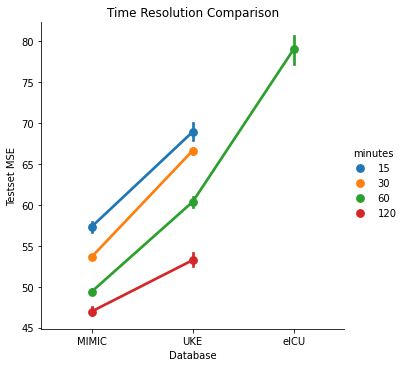

In [51]:
metric = "cross_val_score_tune"
#metric = "test_score"
#metric = "r2"


# minutes!
rnns = df[(df.model_type == "rnn")]
rnns = rnns[(rnns.model_size == "xl")]
rnns = rnns[(rnns.block_size == 256)]
rnns = rnns[(rnns.fill_type == "ffill")]

# use all features
rnns = rnns[rnns.only_med_and_demo_features != True]
rnns = rnns[rnns.use_general_features != True]

rnns = clean_cols(rnns)
rnns = del_stds(rnns)

g = sns.catplot(data=rnns, x="db_name", y=metric,
                #order=['xt', 'tiny', "small", "base", "large", "xl"],
                hue="minutes",
                #hue_order=["linear", "xgb", "transformer", "rnn"],
                #linestyles=["-", "--"],
                kind="point",
               )
    
plt.title("Minutes Comparison for XL RNN")
plt.xlabel("Database")
plt.ylabel("Testset MSE")

name = "minute_comparison"
plot_path = os.path.join(plot_folder, f"{name}")
plt.title("Time Resolution Comparison")
print(f"Saving to {plot_path}")
plt.savefig(plot_path + ".pdf")
plt.savefig(plot_path + ".png", bbox_inches='tight')

rnns
#rnns[["db_name", "bs", "lr", ]

Saving to plots/ind_study/fill_comparison
                   cross_val_score_tune        r2      rmse       mae
db_name fill_type                                                    
MIMIC   ffill                 49.371376  0.177126  6.782614  4.687396
        median                49.005315  0.188669  6.735084  4.593430
        none                  49.834347  0.169661  6.813413  4.635110
UKE     ffill                 60.373525  0.411536  7.702952  4.953911
        median                57.057603  0.412043  7.699682  4.868996
        none                  60.162412  0.392511  7.827305  4.932790
eICU    ffill                 79.055094  0.070043  8.049425  5.290123


/tmp/ipykernel_135167/226438866.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(rnns.groupby(["db_name", "fill_type"]).mean()[["cross_val_score_tune", "r2", "rmse", "mae"]])


,db_name,seed,fill_type,nan_embed_size,nan_embed_transformer_n_layers,bs,lr,weight_decay,grad_clip_val,gpu,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
85,MIMIC,11,median,128,3,2,0.000265,0.32,1.5,0,...,6.735030,0.000148,75.995522,0.943618,0.832498,0.188695,5.792072,4.530372,0.920417,0.748789
13,MIMIC,10,median,128,3,3,0.000405,0.40,0.1,0,...,6.749510,0.000346,76.038277,0.944671,0.834062,0.185181,5.718287,4.445524,0.921692,0.755706
26,MIMIC,10,ffill,128,3,3,0.000030,0.22,1.3,0,...,6.825407,0.000291,76.432579,0.938403,0.827928,0.166760,5.990079,4.670472,0.909477,0.741077
46,MIMIC,12,ffill,128,3,3,0.000116,0.36,0.9,0,...,6.743685,0.000161,74.350464,0.944836,0.823410,0.186606,5.904999,4.561614,0.918479,0.731150
134,MIMIC,19,ffill,128,3,2,0.000098,0.12,0.4,1,...,6.768599,0.000333,74.400002,0.943136,0.827581,0.180582,5.913236,4.611935,0.916487,0.741174
4,MIMIC,1,none,256,4,3,0.000271,0.14,0.6,0,...,6.794584,0.000147,75.270721,0.942603,0.835418,0.174249,5.682337,4.426568,0.920099,0.752986
81,MIMIC,12,median,128,3,2,0.000237,0.22,0.9,0,...,6.720711,0.000145,76.066780,0.944163,0.834124,0.192132,5.763834,4.511202,0.920285,0.751500
27,MIMIC,18,ffill,128,3,4,0.000025,0.00,0.4,1,...,6.848180,0.000276,74.996544,0.935358,0.828986,0.161197,5.916434,4.606479,0.903715,0.738266
5,MIMIC,3,none,256,4,2,0.000281,0.06,0.2,0,...,6.815052,0.000501,75.467529,0.942983,0.833466,0.169294,5.700067,4.472970,0.919727,0.754280
122,MIMIC,11,ffill,128,3,3,0.000162,0.24,0.5,0,...,6.727201,0.000148,74.653145,0.945432,0.826102,0.190484,5.957064,4.599122,0.920975,0.735237


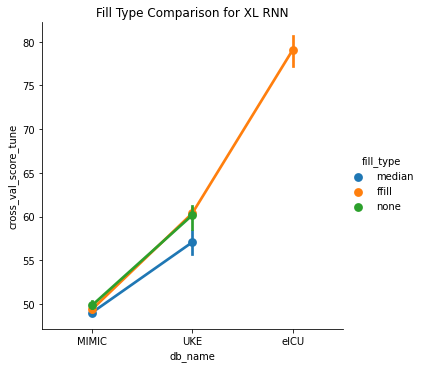

In [55]:
metric = "cross_val_score_tune"
#metric = "test_score"
#metric = "r2"

rnns = df[(df.model_type == "rnn")]
rnns = rnns[(rnns.model_size == "xl")]
rnns = rnns[(rnns.block_size == 256)]
rnns = rnns[(rnns.minutes == 60)]

rnns = rnns[(rnns.fill_type != "none") | (rnns.nan_embed_size == 256)]


# use all features
rnns = rnns[rnns.only_med_and_demo_features != True]
rnns = rnns[rnns.use_general_features != True]


rnns = rnns[rnns.use_nan_embed_transformer != True]


rnns = clean_cols(rnns)
rnns = del_stds(rnns)

g = sns.catplot(data=rnns, x="db_name", y=metric,
                #order=['xt', 'tiny', "small", "base", "large", "xl"],
                hue="fill_type",
                #hue_order=["linear", "xgb", "transformer", "rnn"],
                #linestyles=["-", "--"],
                kind="point",
               )
    
plt.title("Fill Type Comparison for XL RNN")

name = "fill_comparison"
plot_path = os.path.join(plot_folder, f"{name}")
print(f"Saving to {plot_path}")
plt.savefig(plot_path + ".pdf")
plt.savefig(plot_path + ".png", bbox_inches='tight')

print(rnns.groupby(["db_name", "fill_type"]).mean()[["cross_val_score_tune", "r2", "rmse", "mae"]])

rnns
#rnns[["db_name", "bs", "lr", ]

In [64]:
clean_cols(rnns[rnns.fill_type == "none"]).groupby("db_name").apply(lambda x: x.nlargest(1, "cross_val_score_tune"))

,,db_name,seed,bs,lr,weight_decay,grad_clip_val,cross_val_score_tune,test_score,datetime,mse,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
db_name,,,,,,,,,,,,,,,,,,,,,,
MIMIC,145,MIMIC,2,2,0.000271,0.12,0.4,50.329559,46.666996,2023-02-22 05:21:02,46.660782,...,6.830605,0.000138,75.661629,0.941841,0.827491,0.165441,5.739172,4.506887,0.918240,0.743807
UKE,179,UKE,2,2,0.000109,0.22,1.4,61.193718,61.693792,2023-02-21 06:10:10,61.737659,...,7.857225,0.000426,91.969177,0.938915,0.807852,0.387926,5.310006,3.987062,0.926314,0.712086


In [56]:
rnns[["cross_val_score_tune", "db_name", "fill_type"]].sort_values("cross_val_score_tune")

,cross_val_score_tune,db_name,fill_type
85,48.732994,MIMIC,median
13,48.768860,MIMIC,median
26,49.085320,MIMIC,ffill
46,49.118813,MIMIC,ffill
134,49.149071,MIMIC,ffill
4,49.502541,MIMIC,none
81,49.514091,MIMIC,median
27,49.623966,MIMIC,ffill
5,49.670940,MIMIC,none
122,49.879711,MIMIC,ffill


Saving to plots/ind_study/nan_embed_size


,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
97,rnn,MIMIC,60,xl,1,none,64,0,4,2,...,6.829613,0.000113,75.445808,0.942438,0.833769,0.165747,5.692119,4.449522,0.920710,0.753449
4,rnn,MIMIC,60,xl,1,none,256,False,4,3,...,6.794584,0.000147,75.270721,0.942603,0.835418,0.174249,5.682337,4.426568,0.920099,0.752986
138,rnn,MIMIC,60,xl,1,none,128,0,4,4,...,6.920128,0.000293,75.434959,0.939329,0.834862,0.143447,5.620712,4.332708,0.916248,0.757183
3,rnn,MIMIC,60,xl,3,none,512,False,4,2,...,6.799814,0.000330,75.562538,0.942590,0.835393,0.172950,5.476967,4.251598,0.919993,0.755245
5,rnn,MIMIC,60,xl,3,none,256,False,4,2,...,6.815052,0.000501,75.467529,0.942983,0.833466,0.169294,5.700067,4.472970,0.919727,0.754280
113,rnn,MIMIC,60,xl,1,none,512,False,4,2,...,6.803422,0.000148,75.383385,0.942247,0.838309,0.172128,5.643363,4.404639,0.919435,0.759216
87,rnn,MIMIC,60,xl,1,none,32,0,4,2,...,6.861498,0.000122,75.572044,0.942235,0.830086,0.157937,5.754350,4.514976,0.919833,0.752125
121,rnn,MIMIC,60,xl,1,none,1024,False,4,3,...,6.823544,0.000459,75.650085,0.940966,0.839275,0.167230,5.628169,4.368285,0.916753,0.763479
145,rnn,MIMIC,60,xl,2,none,256,False,4,2,...,6.830605,0.000138,75.661629,0.941841,0.827491,0.165441,5.739172,4.506887,0.918240,0.743807
74,rnn,MIMIC,60,xl,2,none,512,False,4,2,...,6.828584,0.000345,75.544899,0.943415,0.829147,0.165999,5.691563,4.444789,0.922250,0.748130


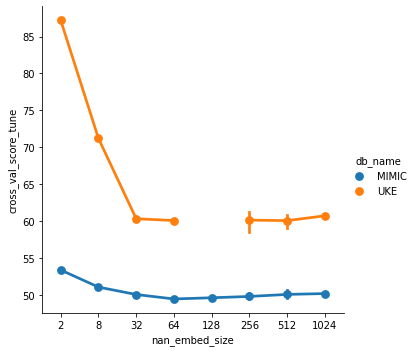

In [34]:
metric = "cross_val_score_tune"
#metric = "test_score"
#metric = "r2"

rnns = df[(df.model_type == "rnn")]
rnns = rnns[(rnns.model_size == "xl")]
rnns = rnns[(rnns.block_size == 256)]
rnns = rnns[(rnns.minutes == 60)]

# use all features
rnns = rnns[rnns.only_med_and_demo_features != True]
rnns = rnns[rnns.use_general_features != True]


rnns = rnns[rnns.use_nan_embed_transformer != True]


rnns = rnns[(rnns.fill_type == "none")]
#rnns = clean_cols(rnns)
rnns = del_stds(rnns)



g = sns.catplot(data=rnns, x="nan_embed_size", y=metric,
                #order=['xt', 'tiny', "small", "base", "large", "xl"],
                hue="db_name",
                #hue_order=["linear", "xgb", "transformer", "rnn"],
                #linestyles=["-", "--"],
                kind="point",
               )
    
name = "nan_embed_size"
plot_path = os.path.join(plot_folder, f"{name}")
print(f"Saving to {plot_path}")
plt.savefig(plot_path + ".pdf")
plt.savefig(plot_path + ".png", bbox_inches='tight')
rnns
#rnns[["db_name", "bs", "lr", ]

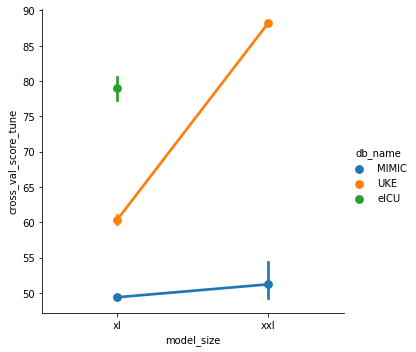

In [35]:
# xxl
metric = "cross_val_score_tune"
#metric = "test_score"
#metric = "r2"


rnns = df[(df.model_type == "rnn")]
rnns = rnns[(rnns.model_size == "xxl") | (rnns.model_size == "xl")]
rnns = rnns[(rnns.fill_type == "ffill") & (rnns.block_size == 256)]
rnns = rnns[(rnns.minutes == 60)]
rnns = rnns[(rnns.use_general_features != True) & (rnns.only_med_and_demo_features != True)]

rnns = clean_cols(rnns)
rnns = del_stds(rnns).sort_values(metric)

g = sns.catplot(data=rnns, x="model_size", y=metric,
                #order=['xt', 'tiny', "small", "base", "large", "xl"],
                hue="db_name",
                #hue_order=["linear", "xgb", "transformer", "rnn"],
                #linestyles=["-", "--"],
                kind="point",
               )

In [36]:
rnns.columns

Index(['db_name', 'model_size', 'seed', 'nan_embed_size',
       'nan_embed_transformer_n_layers', 'bs', 'lr', 'weight_decay',
       'grad_clip_val', 'gpu', 'cross_val_score_tune', 'test_score',
       'datetime', 'mse', 'mae', 'rmse', 'min_abs_error', 'max_abs_error',
       'hyp_acc', 'hyp_auc', 'r2', 'rmse_clin', 'mae_clin', 'hyp_acc_clin',
       'hyp_auc_clin'],
      dtype='object')

In [37]:
rnns

,db_name,model_size,seed,nan_embed_size,nan_embed_transformer_n_layers,bs,lr,weight_decay,grad_clip_val,gpu,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
26,MIMIC,xl,10,128,3,3,0.000030,0.22,1.3,0,...,6.825407,0.000291,76.432579,0.938403,0.827928,0.166760,5.990079,4.670472,0.909477,0.741077
46,MIMIC,xl,12,128,3,3,0.000116,0.36,0.9,0,...,6.743685,0.000161,74.350464,0.944836,0.823410,0.186606,5.904999,4.561614,0.918479,0.731150
134,MIMIC,xl,19,128,3,2,0.000098,0.12,0.4,1,...,6.768599,0.000333,74.400002,0.943136,0.827581,0.180582,5.913236,4.611935,0.916487,0.741174
143,MIMIC,xxl,3,32,4,3,0.000024,0.22,0.7,0,...,6.783040,0.000290,74.211678,0.940433,0.823862,0.177072,5.963392,4.631457,0.910964,0.731289
27,MIMIC,xl,18,128,3,4,0.000025,0.00,0.4,1,...,6.848180,0.000276,74.996544,0.935358,0.828986,0.161197,5.916434,4.606479,0.903715,0.738266
122,MIMIC,xl,11,128,3,3,0.000162,0.24,0.5,0,...,6.727201,0.000148,74.653145,0.945432,0.826102,0.190484,5.957064,4.599122,0.920975,0.735237
69,MIMIC,xxl,2,32,4,4,0.000017,0.02,0.4,0,...,6.809389,0.000099,74.945305,0.939697,0.825545,0.170643,6.011747,4.706610,0.910619,0.736312
45,MIMIC,xxl,1,32,4,4,0.000618,0.08,1.1,0,...,6.778404,0.000162,75.532677,0.945927,0.823712,0.177511,5.883207,4.393210,0.921320,0.733560
238,UKE,xl,11,128,3,3,0.000501,0.10,1.5,0,...,7.760242,0.000180,90.433510,0.938580,0.815274,0.402939,5.312070,4.014536,0.928488,0.713583
186,UKE,xl,18,128,3,2,0.000201,0.26,0.6,1,...,7.577693,0.000157,90.760048,0.940762,0.816439,0.430693,5.265057,3.969559,0.930183,0.718843


In [38]:
df[df["use_nan_embed_transformer"] == True] 

,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
300,rnn,UKE,60,xl,1,none,128,True,1,3,...,7.841183,0.000316,91.415260,0.940112,0.822927,0.390430,5.355404,3.902224,0.927913,0.724328
279,rnn,UKE,60,xl,2,none,8,True,4,2,...,9.616107,0.000103,91.584167,0.907375,0.751593,0.083149,5.559067,4.248163,0.891827,0.675884
295,rnn,UKE,60,xl,2,none,4,True,4,2,...,9.913432,0.003597,90.521301,0.929258,0.656017,0.025515,4.753417,3.571201,0.928403,0.606305


,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
97,rnn,MIMIC,60,xl,1,none,64,False,4,2,...,6.829613,0.000113,75.445808,0.942438,0.833769,0.165747,5.692119,4.449522,0.920710,0.753449
4,rnn,MIMIC,60,xl,1,none,256,False,4,3,...,6.794584,0.000147,75.270721,0.942603,0.835418,0.174249,5.682337,4.426568,0.920099,0.752986
138,rnn,MIMIC,60,xl,1,none,128,False,4,4,...,6.920128,0.000293,75.434959,0.939329,0.834862,0.143447,5.620712,4.332708,0.916248,0.757183
3,rnn,MIMIC,60,xl,3,none,512,False,4,2,...,6.799814,0.000330,75.562538,0.942590,0.835393,0.172950,5.476967,4.251598,0.919993,0.755245
5,rnn,MIMIC,60,xl,3,none,256,False,4,2,...,6.815052,0.000501,75.467529,0.942983,0.833466,0.169294,5.700067,4.472970,0.919727,0.754280
113,rnn,MIMIC,60,xl,1,none,512,False,4,2,...,6.803422,0.000148,75.383385,0.942247,0.838309,0.172128,5.643363,4.404639,0.919435,0.759216
87,rnn,MIMIC,60,xl,1,none,32,False,4,2,...,6.861498,0.000122,75.572044,0.942235,0.830086,0.157937,5.754350,4.514976,0.919833,0.752125
121,rnn,MIMIC,60,xl,1,none,1024,False,4,3,...,6.823544,0.000459,75.650085,0.940966,0.839275,0.167230,5.628169,4.368285,0.916753,0.763479
145,rnn,MIMIC,60,xl,2,none,256,False,4,2,...,6.830605,0.000138,75.661629,0.941841,0.827491,0.165441,5.739172,4.506887,0.918240,0.743807
74,rnn,MIMIC,60,xl,2,none,512,False,4,2,...,6.828584,0.000345,75.544899,0.943415,0.829147,0.165999,5.691563,4.444789,0.922250,0.748130


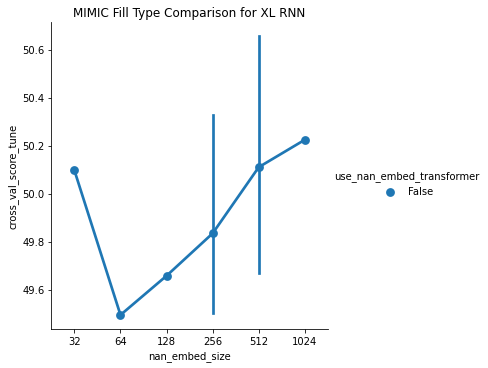

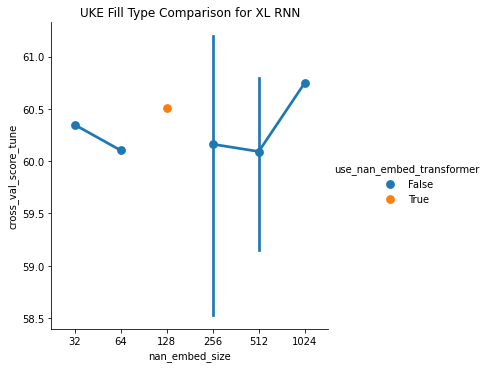

In [39]:
# investigate nan embed transformer - use_nan_embed_transformer

if df["use_nan_embed_transformer"].sum() > 0:
    metric = "cross_val_score_tune"
    #metric = "test_score"
    #metric = "r2"

    rnns = df[(df.model_type == "rnn")]
    rnns = rnns[(rnns.model_size == "xl")]
    rnns = rnns[(rnns.block_size == 256)]
    rnns = rnns[(rnns.minutes == 60)]
    # use all features
    rnns = rnns[rnns.only_med_and_demo_features != True]
    rnns = rnns[rnns.use_general_features != True]
    rnns = rnns[(rnns.fill_type == "none")]

    
    rnns = rnns[(rnns.nan_embed_size >8)]

    #rnns = clean_cols(rnns)
    rnns = del_stds(rnns)

    rnns.use_nan_embed_transformer = rnns.use_nan_embed_transformer.astype(bool)

    for db in rnns.db_name.unique():
        db_df = rnns[rnns.db_name == db]
        g = sns.catplot(data=db_df, x="nan_embed_size", y=metric,
                        #order=['xt', 'tiny', "small", "base", "large", "xl"],
                        hue="use_nan_embed_transformer",
                        #hue_order=["linear", "xgb", "transformer", "rnn"],
                        #linestyles=["-", "--"],
                        kind="point",
                       )

        plt.title(f"{db} Fill Type Comparison for XL RNN")

rnns

In [40]:
rnns[["cross_val_score_tune", "db_name"]]

,cross_val_score_tune,db_name
97,49.494366,MIMIC
4,49.502541,MIMIC
138,49.657631,MIMIC
3,49.669674,MIMIC
5,49.670940,MIMIC
113,50.005360,MIMIC
87,50.096844,MIMIC
121,50.224358,MIMIC
145,50.329559,MIMIC
74,50.655334,MIMIC


In [41]:
rnns.columns

Index(['model_type', 'db_name', 'minutes', 'model_size', 'seed', 'fill_type',
       'nan_embed_size', 'use_nan_embed_transformer',
       'nan_embed_transformer_n_layers', 'bs', 'block_size', 'lr',
       'use_nan_embed', 'weight_decay', 'grad_clip_val', 'dropout',
       'flat_block_size', 'alpha', 'l1_ratio', 'n_estimators', 'max_depth',
       'min_child_weight', 'gamma', 'subsample', 'colsample_bytree', 'gpu',
       'cross_val_score_tune', 'test_score', 'datetime',
       'only_med_and_demo_features', 'use_general_features', 'mse', 'mae',
       'rmse', 'min_abs_error', 'max_abs_error', 'hyp_acc', 'hyp_auc', 'r2',
       'rmse_clin', 'mae_clin', 'hyp_acc_clin', 'hyp_auc_clin'],
      dtype='object')

,db_name,seed,nan_embed_size,nan_embed_transformer_n_layers,bs,lr,weight_decay,grad_clip_val,gpu,cross_val_score_tune,...,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin,feature_type
56,MIMIC,3,32,4,2,0.000154,0.34,0.4,1,49.018761,...,0.000442,76.047096,0.945216,0.789655,0.123072,5.541337,4.276923,0.927242,0.733194,only_med
26,MIMIC,10,128,3,3,0.000030,0.22,1.3,0,49.085320,...,0.000291,76.432579,0.938403,0.827928,0.166760,5.990079,4.670472,0.909477,0.741077,all
46,MIMIC,12,128,3,3,0.000116,0.36,0.9,0,49.118813,...,0.000161,74.350464,0.944836,0.823410,0.186606,5.904999,4.561614,0.918479,0.731150,all
134,MIMIC,19,128,3,2,0.000098,0.12,0.4,1,49.149071,...,0.000333,74.400002,0.943136,0.827581,0.180582,5.913236,4.611935,0.916487,0.741174,all
153,MIMIC,3,32,4,2,0.000072,0.00,1.5,0,49.446190,...,0.000176,74.673164,0.945001,0.762342,0.096720,5.749876,4.302212,0.927268,0.683944,general
14,MIMIC,2,32,4,3,0.000044,0.08,1.0,1,49.526268,...,0.000338,76.093254,0.944658,0.785287,0.117202,5.569036,4.301527,0.923763,0.728592,only_med
27,MIMIC,18,128,3,4,0.000025,0.00,0.4,1,49.623966,...,0.000276,74.996544,0.935358,0.828986,0.161197,5.916434,4.606479,0.903715,0.738266,all
122,MIMIC,11,128,3,3,0.000162,0.24,0.5,0,49.879711,...,0.000148,74.653145,0.945432,0.826102,0.190484,5.957064,4.599122,0.920975,0.735237,all
72,MIMIC,2,32,4,3,0.000061,0.36,1.2,0,49.930733,...,0.000259,74.200485,0.944214,0.769603,0.095325,5.742177,4.300263,0.926551,0.693397,general
147,MIMIC,1,32,4,2,0.000106,0.34,0.6,1,54.931385,...,0.000239,76.158401,0.943618,0.788216,0.119445,5.619330,4.344703,0.922621,0.731275,only_med


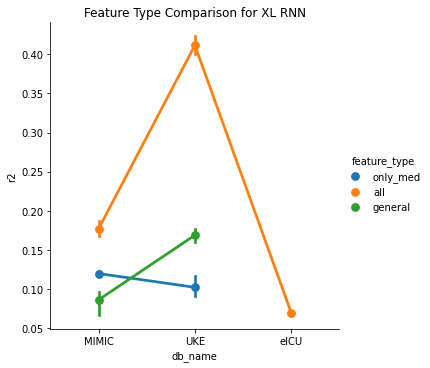

In [42]:
metric = "cross_val_score_tune"
#metric = "test_score"
metric = "r2"

rnns = df[(df.model_type == "rnn")]
rnns = rnns[(rnns.model_size == "xl")]
rnns = rnns[(rnns.block_size == 256)]
rnns = rnns[(rnns.minutes == 60)]

# use all features
rnns["feature_type"] = "all"
rnns.loc[rnns.only_med_and_demo_features == True, "feature_type"] = "only_med"
rnns.loc[rnns.use_general_features == True, "feature_type"] = "general"


rnns = rnns[(rnns.fill_type == "ffill")]

rnns = clean_cols(rnns)
rnns = del_stds(rnns)



g = sns.catplot(data=rnns, x="db_name", y=metric,
                #order=['xt', 'tiny', "small", "base", "large", "xl"],
                hue="feature_type",
                #hue_order=["linear", "xgb", "transformer", "rnn"],
                #linestyles=["-", "--"],
                kind="point",
               )
    
plt.title("Feature Type Comparison for XL RNN")

rnns
#rnns[["db_name", "bs", "lr", ]

In [43]:
unnecessary_cols = ["min_abs_error", "max_abs_error", "hyp_acc_clin", "hyp_auc_clin", "seed", "gpu"]

means = rnns.groupby("db_name").apply(lambda db: db.groupby("feature_type").mean(numeric_only=True)).drop(columns=unnecessary_cols)
stds = rnns.groupby("db_name").apply(lambda db: db.groupby("feature_type").std(numeric_only=True)).drop(columns=unnecessary_cols)
means["hyp_auc"] *= 100
stds["hyp_auc"] *= 100
means["hyp_acc"] *= 100
stds["hyp_acc"] *= 100

metric_cols = ["test_score", "mse","rmse", "mae", "hyp_acc", "hyp_auc", "r2", "rmse_clin", "mae_clin", "cross_val_score_tune"]
means[metric_cols].round(3)
metric_cols = ["test_score", "rmse", "mae", "hyp_acc", "hyp_auc", "r2", "rmse_clin", "mae_clin", "cross_val_score_tune"]
stds[metric_cols].round(3)
str_table = means[metric_cols].round(2).astype(str)  + " +- " + stds[metric_cols].round(2).astype(str) 
str_table.reset_index()
str_table.to_csv("plots/ind_study/table_features.csv")

In [44]:
(block_df.groupby(["db_name", "model_type", "block"]).count())["mse"]

db_name  model_type   block
MIMIC    linear       32       3
         rnn          256      5
         transformer  256      4
         xgb          8        5
UKE      linear       32       3
         rnn          256      5
         transformer  256      5
         xgb          8        6
eICU     rnn          256      3
         xgb          8        3
Name: mse, dtype: int64

In [45]:
(block_df.groupby(["db_name", "model_type", "block"]).std() * 100).round()["mse"]

/tmp/ipykernel_135167/2736776656.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (block_df.groupby(["db_name", "model_type", "block"]).std() * 100).round()["mse"]


db_name  model_type   block
MIMIC    linear       32         4.0
         rnn          256       71.0
         transformer  256      135.0
         xgb          8        147.0
UKE      linear       32         3.0
         rnn          256      154.0
         transformer  256      124.0
         xgb          8         99.0
eICU     rnn          256       17.0
         xgb          8        182.0
Name: mse, dtype: float64

In [46]:
df[df["db_name"] == "MIMIC"].sort_values("cross_val_score_tune")

,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
334,rnn,MIMIC,120,xl,1,ffill,128,0,3,3,...,6.543535,0.000209,76.016258,0.944492,0.834469,0.198823,5.943817,4.627649,0.909826,0.741587
333,rnn,MIMIC,120,xl,3,ffill,128,0,3,4,...,6.495756,0.000366,76.026176,0.946940,0.831780,0.210461,5.940111,4.616974,0.913039,0.734204
332,rnn,MIMIC,120,xl,2,ffill,128,0,3,3,...,6.602162,0.000347,74.925720,0.939807,0.838893,0.184415,5.902086,4.622775,0.904177,0.749661
85,rnn,MIMIC,60,xl,11,median,128,0,3,2,...,6.735030,0.000148,75.995522,0.943618,0.832498,0.188695,5.792072,4.530372,0.920417,0.748789
13,rnn,MIMIC,60,xl,10,median,128,0,3,3,...,6.749510,0.000346,76.038277,0.944671,0.834062,0.185181,5.718287,4.445524,0.921692,0.755706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,xgb,MIMIC,60,base,4,ffill,128,0,3,8,...,6.865057,0.000103,75.443306,0.940080,0.827939,0.157172,5.812813,4.334093,0.914450,0.736247
96,transformer,MIMIC,60,xl,2,ffill,128,0,3,4,...,7.376154,0.000145,75.068138,0.935840,0.811750,0.025503,6.683067,4.867054,0.908973,0.729776
82,xgb,MIMIC,60,base,3,ffill,128,0,3,8,...,6.943765,0.000487,74.424942,0.940067,0.824919,0.137676,5.818222,4.312082,0.914158,0.737594
28,xgb,MIMIC,60,base,3,ffill,128,0,3,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df[df["db_name"] == "UKE"].sort_values("cross_val_score_tune")

,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
313,rnn,UKE,120,xl,3,ffill,128,0,3,4,...,7.331755,0.000160,88.362335,0.947231,0.839761,0.451256,5.011549,3.813950,0.937513,0.740092
315,rnn,UKE,120,xl,1,ffill,128,0,3,4,...,7.534147,0.000397,85.099854,0.943513,0.831438,0.420578,5.022052,3.794744,0.934574,0.731955
314,rnn,UKE,120,xl,2,ffill,128,0,3,2,...,7.289455,0.000063,84.512718,0.947791,0.834951,0.457684,4.966116,3.720097,0.937551,0.733397
170,rnn,UKE,60,xl,11,median,128,0,3,2,...,7.523767,0.000245,90.580574,0.943044,0.823638,0.438777,5.275828,3.937595,0.930631,0.722529
306,rnn,UKE,60,xl,10,median,128,0,3,2,...,7.820070,0.000134,91.874542,0.940005,0.811248,0.393651,5.230597,3.906630,0.927593,0.718448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,transformer,UKE,60,base,2,ffill,128,0,3,5,...,8.663568,0.000230,90.140236,0.927826,0.793786,0.255751,5.879947,4.145474,0.918375,0.695263
194,linear,UKE,60,base,11,ffill,128,0,3,8,...,9.393249,0.000045,87.517614,0.937964,0.769572,0.125248,4.671941,3.577294,0.937430,0.658937
229,transformer,UKE,60,large,1,ffill,128,0,3,3,...,8.435943,0.000105,92.598213,0.929626,0.803925,0.294372,5.855627,4.268050,0.919046,0.713359
279,rnn,UKE,60,xl,2,none,8,True,4,2,...,9.616107,0.000103,91.584167,0.907375,0.751593,0.083149,5.559067,4.248163,0.891827,0.675884


In [48]:


df[df["model_type"] != "xgb"]

,model_type,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
334,rnn,MIMIC,120,xl,1,ffill,128,0,3,3,...,6.543535,0.000209,76.016258,0.944492,0.834469,0.198823,5.943817,4.627649,0.909826,0.741587
333,rnn,MIMIC,120,xl,3,ffill,128,0,3,4,...,6.495756,0.000366,76.026176,0.946940,0.831780,0.210461,5.940111,4.616974,0.913039,0.734204
332,rnn,MIMIC,120,xl,2,ffill,128,0,3,3,...,6.602162,0.000347,74.925720,0.939807,0.838893,0.184415,5.902086,4.622775,0.904177,0.749661
85,rnn,MIMIC,60,xl,11,median,128,0,3,2,...,6.735030,0.000148,75.995522,0.943618,0.832498,0.188695,5.792072,4.530372,0.920417,0.748789
13,rnn,MIMIC,60,xl,10,median,128,0,3,3,...,6.749510,0.000346,76.038277,0.944671,0.834062,0.185181,5.718287,4.445524,0.921692,0.755706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,transformer,UKE,60,base,2,ffill,128,0,3,5,...,8.663568,0.000230,90.140236,0.927826,0.793786,0.255751,5.879947,4.145474,0.918375,0.695263
194,linear,UKE,60,base,11,ffill,128,0,3,8,...,9.393249,0.000045,87.517614,0.937964,0.769572,0.125248,4.671941,3.577294,0.937430,0.658937
229,transformer,UKE,60,large,1,ffill,128,0,3,3,...,8.435943,0.000105,92.598213,0.929626,0.803925,0.294372,5.855627,4.268050,0.919046,0.713359
279,rnn,UKE,60,xl,2,none,8,True,4,2,...,9.616107,0.000103,91.584167,0.907375,0.751593,0.083149,5.559067,4.248163,0.891827,0.675884


In [49]:
lstms = df[df["model_type"] == "rnn"]
lstms = lstms.drop(columns=lstms.nunique()[lstms.nunique()<=1].index)
lstms

,db_name,minutes,model_size,seed,fill_type,nan_embed_size,use_nan_embed_transformer,nan_embed_transformer_n_layers,bs,block_size,...,rmse,min_abs_error,max_abs_error,hyp_acc,hyp_auc,r2,rmse_clin,mae_clin,hyp_acc_clin,hyp_auc_clin
334,MIMIC,120,xl,1,ffill,128,0,3,3,256,...,6.543535,0.000209,76.016258,0.944492,0.834469,0.198823,5.943817,4.627649,0.909826,0.741587
333,MIMIC,120,xl,3,ffill,128,0,3,4,256,...,6.495756,0.000366,76.026176,0.946940,0.831780,0.210461,5.940111,4.616974,0.913039,0.734204
332,MIMIC,120,xl,2,ffill,128,0,3,3,256,...,6.602162,0.000347,74.925720,0.939807,0.838893,0.184415,5.902086,4.622775,0.904177,0.749661
85,MIMIC,60,xl,11,median,128,0,3,2,256,...,6.735030,0.000148,75.995522,0.943618,0.832498,0.188695,5.792072,4.530372,0.920417,0.748789
13,MIMIC,60,xl,10,median,128,0,3,3,256,...,6.749510,0.000346,76.038277,0.944671,0.834062,0.185181,5.718287,4.445524,0.921692,0.755706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,UKE,60,xl,1,none,2,0,4,2,256,...,9.322577,0.000202,90.772926,0.932631,0.781409,0.138254,5.066792,3.905043,0.924950,0.694870
285,UKE,60,xxl,1,ffill,32,0,4,4,256,...,7.740101,0.000179,90.636108,0.938439,0.813754,0.405962,5.440670,4.023266,0.928936,0.713730
274,UKE,60,xl,1,ffill,32,0,4,3,256,...,9.441261,0.000202,91.894432,0.930864,0.708505,0.116165,5.317257,3.834214,0.928616,0.637379
279,UKE,60,xl,2,none,8,True,4,2,16,...,9.616107,0.000103,91.584167,0.907375,0.751593,0.083149,5.559067,4.248163,0.891827,0.675884


In [50]:
x = "cross_val_score_tune"
y = "test_score"

import seaborn as sns
#p = sns.regplot(x=x, y=y, data=all_df)

sns.jointplot(x=x, y=y, data=all_df)


NameError: name 'all_df' is not defined

In [ ]:
all_df = all_df.drop(columns=["tree_method", "gpu"])
# fill freeze nan embed nans with 0
all_df.loc[all_df["freeze_nan_embed"] == "NaN", "freeze_nan_embed"] = 0
all_df = all_df[all_df["freeze_nan_embed"] != 1].drop(columns=["freeze_nan_embed"])
# fill norm nan embed nans with 0
all_df.loc[all_df["norm_nan_embed"] == "NaN", "norm_nan_embed"] = 0
all_df = all_df[all_df["norm_nan_embed"] != 0].drop(columns=["norm_nan_embed"])

In [ ]:
final_df = all_df[all_df["max_epochs"] == 30]
final_df = final_df[final_df["opt_steps"] == 200]

In [ ]:
final_df.to_csv("tunings/final_df.csv")

In [ ]:
final_df.columns

In [ ]:
score_comp = final_df[["model_type", "db_name", "val_score_mean", "test_score_mean",
                       "nan_embed_size",
                      "pretrained", "hidden_size", "fill_type", "flat_block_size", "val_score_std", 
                      "test_score_std", "gpt_name", "max_len", "block_size"]]

In [ ]:
score_comp

In [ ]:
all_cfgs[0].keys()

In [ ]:
final_df.columns

In [ ]:
nan_embeds = all_df.dropna(subset=["nan_embed_size"])
nan_embeds = nan_embeds[nan_embeds["model_type"] =="mlp"]
nan_embeds = nan_embeds[nan_embeds["fill_type"] == "none"]
nan_embeds = nan_embeds[nan_embeds["norm_nan_embed"] == 1]

reduced = nan_embeds[["db_name", "fill_type", "nan_embed_size",
                     "norm_nan_embed", "freeze_nan_embed", "val_score_mean"]]
reduced.sort_values(by=["val_score_mean"], ascending=False, inplace=False)

In [ ]:
all_df.columns

In [ ]:
db = "UKE"
fill_type = "ffill"# "none", "median"
param = "param_count"   # hidden_size, num_transformer_blocks, param_count
#"num_transformer_blocks"


val_name = "cross_val_score_tune"
test_name = "test_score"

plot_df = all_df[all_df["db_name"] == db].sort_values("model_type").drop(columns=["db_name"])

first_models = plot_df[plot_df["fill_type"] == fill_type]

import matplotlib.pyplot as plt

ax = plt.figure(figsize=(8,5)).gca()



# rnn best hidden size
rnn_df = first_models[first_models["model_type"] == "rnn"].sort_values("hidden_size").copy()
rnn_df["param_count"] = rnn_df["hidden_size"] * rnn_df["rnn_layers"]
rnn_df = rnn_df.groupby(groupby).mean().reset_index()
ax1 = rnn_df.plot(x=param, y=val_name, kind="line", label="rnn val", style="-X", ax=ax)
ax = rnn_df.plot(x=param, y=test_name, kind="line", label="rnn test", style="-X", ax=ax)

transformer_df = first_models[first_models["model_type"] == "transformer"].sort_values("hidden_size").copy()
transformer_df["param_count"] = transformer_df["hidden_size"] * transformer_df["num_transformer_blocks"]
transformer_df = transformer_df.groupby(groupby).mean().reset_index()
ax1 = transformer_df.plot(x=param, y=val_name, kind="line", label="trans val", style="-X", ax=ax)
ax = transformer_df.plot(x=param, y=test_name, kind="line", label="trans test", style="-X", ax=ax)


plt.grid(True)
plt.ylabel("MSE")
plt.xlabel(param)
plt.title(f"Score changes in dependence of hidden size for {db}")
# x-axis in log2 scale
#plt.xscale('log', base=2)
# put legend at top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
            fancybox=True, shadow=True, ncol=5)
#rnn_df[["hidden_size", "val_score_mean", "val_score_std", "test_score_mean", "test_score_std"]]


In [ ]:
rnn_df.sort_values("cross_val_score_tune")

In [ ]:
all_df[all_df["db_name"] == "UKE"].sort_values("cross_val_score_tune")

In [ ]:
all_df[all_df["db_name"] == "UKE"].sort_values("cross_val_score_tune").iloc[0].to_dict()

In [ ]:
db = "UKE"
fill_type = "median"  # "none", "median"

plot_df = score_comp[score_comp["db_name"] == db].sort_values("model_type").drop(columns=["db_name"])

first_models = plot_df[plot_df["fill_type"] == fill_type]

import matplotlib.pyplot as plt

ax = plt.figure(figsize=(8,5)).gca()
# rnn best hidden size
rnn_df = first_models[first_models["model_type"] == "rnn"].sort_values("hidden_size").copy()
ax1 = rnn_df.plot(x="hidden_size", y="val_score_mean", kind="line", label="val", style="-X", ax=ax)
ax = rnn_df.plot(x="hidden_size", y="test_score_mean", kind="line", label="test", style="-X", ax=ax)

mlp_df = first_models[first_models["model_type"] == "mlp"].sort_values("hidden_size").copy()
mlp_df.plot(x="hidden_size", y="val_score_mean", kind="line", label="val", style="-o", ax=ax)
mlp_df.plot(x="hidden_size", y="test_score_mean", kind="line", label="test", style="-o", ax=ax)

plt.grid(True)
plt.ylabel("R2 score")
plt.xlabel("Hidden Size")
plt.title(f"Score changes in dependence of hidden size for {db}")
# x-axis in log2 scale
#plt.xscale('log', base=2)
# put legend at top
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
            fancybox=True, shadow=True, ncol=5)
#rnn_df[["hidden_size", "val_score_mean", "val_score_std", "test_score_mean", "test_score_std"]]


In [ ]:
def clean_df(df):
    # drop columsn that only have one unique value
    df = df.drop(columns=df.nunique()[df.nunique()<=1].index)
    # for each column name that appears twice, only keep one
    df = df.loc[:,~df.columns.duplicated()]
    return df


In [ ]:
# investigate block size performance
rnn_models = all_df[all_df["model_type"] == "rnn"].sort_values("block_size")
rnn_models = rnn_models[rnn_models["db_name"] == "MIMIC"]
rnn_models = rnn_models[rnn_models["fill_type"] == "none"]

rnn_models = clean_df(rnn_models)
best = rnn_models.groupby("block_size").apply(lambda x: x.nlargest(1, "test_score_mean")).reset_index(drop=True)
print(best)
print()

mlp_models = all_df[all_df["model_type"] == "mlp"].sort_values("block_size")
mlp_models = mlp_models[mlp_models["db_name"] == "UKE"]
#rnn_models = rnn_models[rnn_models["fill_type"] == "none"]
# sort out rows where, if the fill type is none and the nan_embed_size different from 512
mlp_models = mlp_models[(mlp_models["fill_type"] == "median") | (mlp_models["nan_embed_size"] == 512)]
mlp_models = clean_df(mlp_models)
best = mlp_models.groupby("block_size").apply(lambda x: x.nlargest(1, "test_score_mean")).reset_index(drop=True)
print(best)
mlp_models



In [ ]:
all_df.sort_values("block_size")

In [ ]:
plot_df.sort_values("block_size")

In [ ]:
# plot gpt sizes
gpt_models = all_df[all_df["model_type"] == "gpt"]
gpt_models = gpt_models[gpt_models["pretrained"] == 1]
gpt_models = gpt_models[gpt_models["db_name"] == "UKE"]
gpt_models = gpt_models[gpt_models["fill_type"] == "median"]
# drop columsn that only have one unique value
gpt_models = gpt_models.drop(columns=gpt_models.nunique()[gpt_models.nunique()<=1].index)
# for each column name that appears twice, only keep one
gpt_models = gpt_models.loc[:,~gpt_models.columns.duplicated()]



gpt_sizes = gpt_models[gpt_models["reduction_factor"] == 16]
gpt_sizes = gpt_sizes[gpt_sizes["max_len"] == 512].sort_values("reduction_factor")

ax = gpt_sizes.plot(x="gpt_name", y="test_score_mean", kind="line", label="test", style="-X")
ax = gpt_sizes.plot(x="gpt_name", y="val_score_mean", kind="line", label="val", style="-X", ax=ax)

# set correct x-ticks with gpt names
plt.xticks(range(len(gpt_sizes)), gpt_sizes["gpt_name"])
plt.grid(True)
#plt.yticks(np.arange(0.52, 0.55, 0.01))

gpt_sizes


In [ ]:
gpt_reduction_facs = gpt_models[gpt_models["gpt_name"] == "gpt2"]
gpt_reduction_facs = gpt_reduction_facs[gpt_reduction_facs["max_len"] == 512].sort_values("reduction_factor")

ax = gpt_reduction_facs.plot(x="reduction_factor", y="test_score_mean", kind="line", label="val", style="-X")
gpt_reduction_facs.plot(x="reduction_factor", y="val_score_mean", kind="line", label="test", style="-X", ax=ax)

# enabled grid 
plt.grid(True)
# make nicer
plt.ylabel("R2 score")
plt.xlabel("Reduction Factor")
plt.title(f"Score changes in dependence of reduction factor for {db}")
# only show relevant y ticks
import numpy as np
#plt.yticks(np.arange(0.4, 0.55, 0.01))

# gpt_reduction_facs


In [ ]:
gpt_reduction_facs

In [ ]:
# plot for best model per model type
best_models = first_models.copy().sort_values("model_type")
#best_models = best_models[best_models[(best_models["hidden_size"] == 2048) & (best_models["hidden_size"] == 2048)]]
#best_models = best_models[best_models["gpt_name"] == "gpt2"]

best_models = best_models[best_models["block_size"] == 128]

#best_models = best_models[(best_models["pretrained"] == 0) | (best_models["model_type"] != "gpt")]
#best_models = best_models.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)
# capitalize model_type
best_models["model_type"] = best_models["model_type"].str.upper()
ax1 = best_models.plot(x="model_type", y="val_score_mean", kind="line", label="val", style="-X")
ax2 = best_models.plot(x="model_type", y="test_score_mean", kind="line", label="test", ax=ax1, style="-X")
plt.ylabel("R2 score")
plt.xlabel("Model Type")
plt.title(f"Score changes in dependence of model type for {db}")
# enabled grid
plt.grid(True)


#sns.barplot(x="model_type", y="val_score_mean", data=best_models)
# plot with std as error bar
#sns.barplot(x="model_type", y="val_score_mean", data=best_models, yerr="val_score_std")
best_models


In [ ]:
fill_type_df = plot_df[plot_df["hidden_size"] == 2048].sort_values("model_type")

fill_type_df
#best_models = plot_df.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)



In [ ]:
rows = []
for model_type in fill_type_df["model_type"].unique():
    model_type_df = fill_type_df[fill_type_df["model_type"] == model_type]
    for fill_type in model_type_df["fill_type"].unique():
        sub_df = model_type_df[model_type_df["fill_type"] == fill_type]
        best = sub_df.nlargest(1, "val_score_mean")
        rows.append(best)

pd.concat(rows).sort_values("test_score_mean", ascending=False)
       
#fill_type_df.groupby("model_type").apply(lambda model_df: model_df.groupby("fill_type").apply(lambda x: x.nlargest(1, "val_score_mean")))

In [ ]:
fill_type_df.groupby("model_type").mean().reset_index().sort_values("test_score_mean", ascending=False)